# Install libraries

In [1]:
!pip install monai albumentations==1.4.24 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 7.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 48.2 MB/s eta 0:00:00a 0:00:01


# extract the path

In [2]:
import os
from pathlib import Path

import cv2
from matplotlib import pyplot as plt


train_path = "/kaggle/input/datasets/nguyentduc/oai-knee-x-ray-anatomy-segmentation-dataset/knee_data_segmentation/train"
val_path   = "/kaggle/input/datasets/nguyentduc/oai-knee-x-ray-anatomy-segmentation-dataset/knee_data_segmentation/val"
test_path  = "/kaggle/input/datasets/nguyentduc/oai-knee-x-ray-anatomy-segmentation-dataset/knee_data_segmentation/test"


# Implement a custom Dataset class

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

class KneeDataset(Dataset):
    def __init__(self, root_path:str| Path, transform=None):
        root_dir = {
            f.name: f for f in Path(root_path).iterdir() if f.is_dir()
        }
        img_dir = root_dir["images"]
        mks_dir = root_dir["masks"]

        self.image_paths = [str(f) for f in sorted(Path(img_dir).rglob("*")) if f.is_file()]
        self.mask_paths  = [str(f) for f in sorted(Path(mks_dir).rglob("*")) if f.is_file()]
        self.transform   = transform

    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx:int):
        img_path = self.image_paths[idx]
        msk_path = self.mask_paths[idx]

        image = np.asarray(cv2.imread(img_path, cv2.IMREAD_UNCHANGED))
        mask  = np.asarray(cv2.imread(msk_path, cv2.IMREAD_UNCHANGED))
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask  = augmented["mask"]
        return image, mask

/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Define transforms

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    # Resize giữ tỉ lệ
    A.LongestMaxSize(max_size=512),

    # Pad đủ vuông
    A.PadIfNeeded(
        min_height=512,
        min_width=512,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
    ),

    # -------------------------
    # Geometric (nhẹ và hợp lý)
    # -------------------------

    # HorizontalFlip hợp lý cho knee X-ray
    A.HorizontalFlip(p = 0.3), 
    A.VerticalFlip(p = 0.3), 

    A.ShiftScaleRotate(
        shift_limit=0.3,     #  30%
        scale_limit=0.1,     # scale ±10%
        rotate_limit=45,       # chỉ ±45độ
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
        p=0.3,
    ),

     A.CoarseDropout(
        num_holes_range=(2, 3),
        hole_height_range=(16, 64),   # 3% → 12% của 512
        hole_width_range=(16, 64),
        fill=0,
        p=0.2
    ),

    # -------------------------
    # Intensity (nhẹ)
    # -------------------------

    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.1,
        p=0.2
    ),

    A.RandomGamma(
        gamma_limit=(90, 110),
        p=0.2
    ),

    # -------------------------
    # Normalize
    # -------------------------
    
    A.Normalize(normalization="min_max"),
    ToTensorV2(),
])


test_transform = A.Compose([
    # Resize giữ tỉ lệ
    A.LongestMaxSize(max_size=512),

    # Pad đủ vuông
    A.PadIfNeeded(
        min_height=512,
        min_width=512,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0,
    ),
    A.Normalize(normalization="min_max"),
    ToTensorV2()],)

# Initialize the dataset and DataLoader

In [5]:
train_set = KneeDataset(train_path, train_transform)
val_set   = KneeDataset(val_path, test_transform)
test_set  = KneeDataset(test_path, test_transform)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2,  drop_last=True)
val_loader   = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=8,shuffle=False, num_workers=2)

# Display a few sample images

type : <class 'torch.Tensor'>
max  : 0.9999995652175804
min  : 0.0
shape: (1, 512, 512)


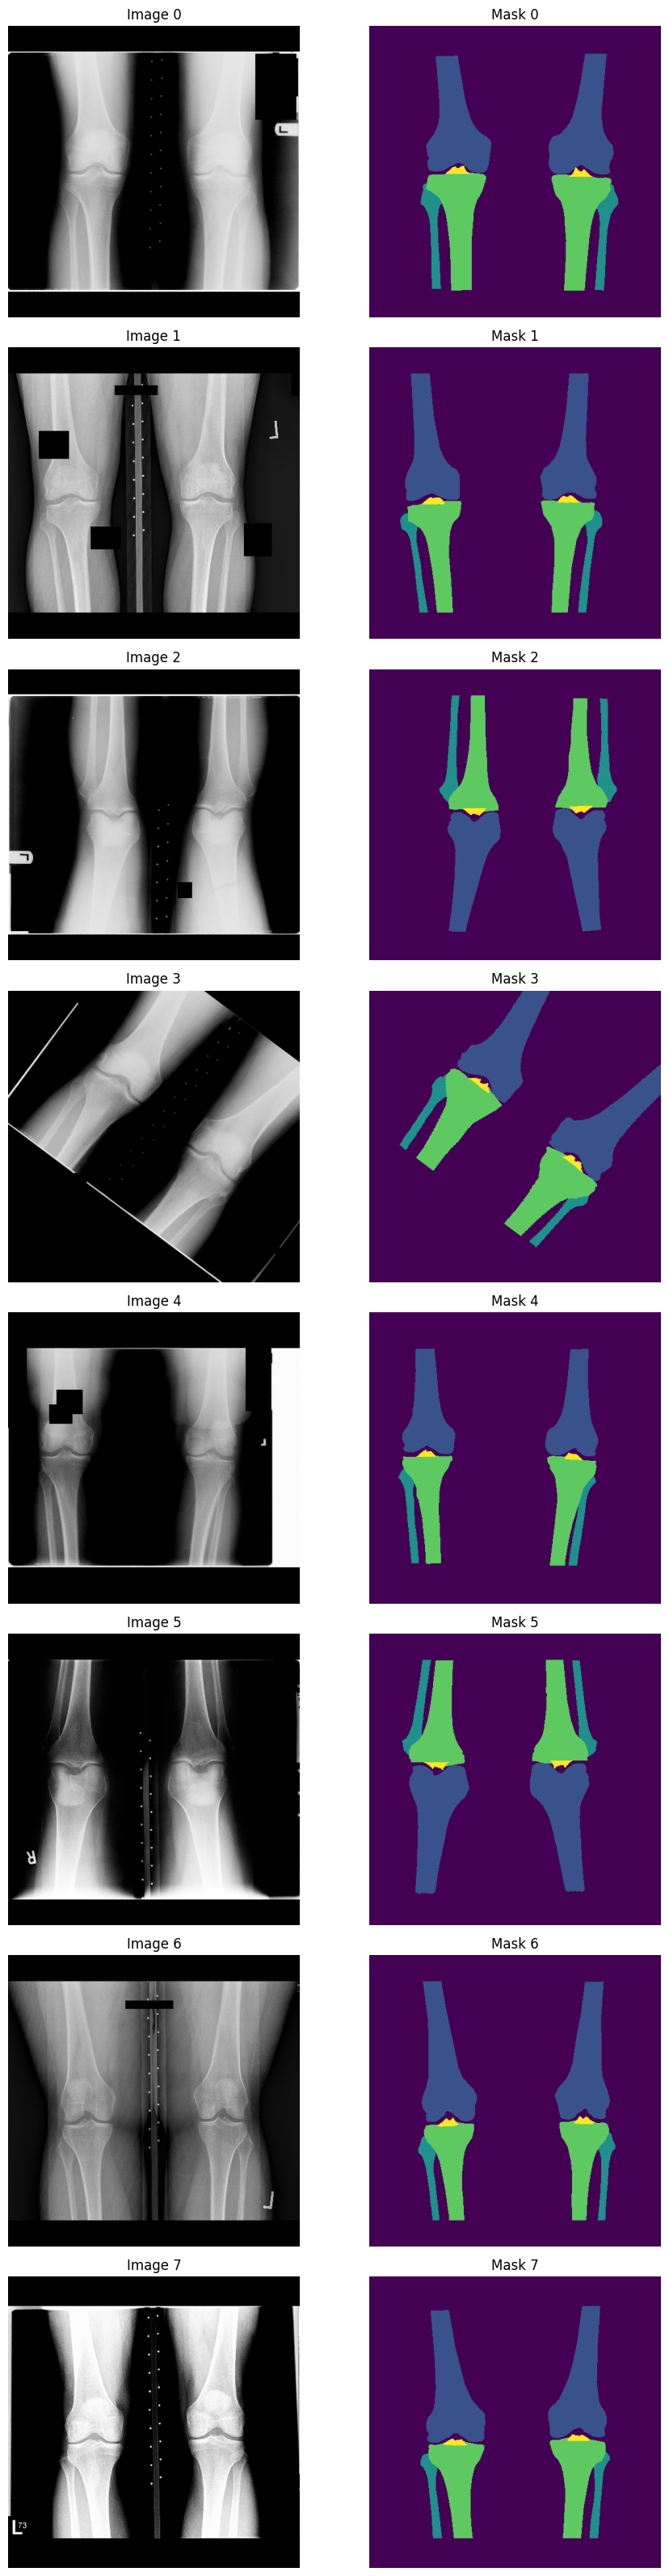

In [6]:
import matplotlib.pyplot as plt

images, masks = next(iter(train_loader))  # images: (B,C,H,W), masks: (B,...) tùy bài

# ---- Debug 1 sample (index=1) ----
x = images[1]
print("type :", type(x))
print("max  :", float(x.max()))
print("min  :", float(x.min()))
print("shape:", tuple(x.shape))  # (C,H,W)

# ---- Plot 8 samples: (image, mask) per row ----
n = 8
plt.figure(figsize=(10, 4*n))

for i in range(n):
    # ===== image =====
    img = images[i].detach().cpu()  # (C,H,W)
    if img.ndim == 3 and img.shape[0] == 1:
        img = img[0]               # (H,W)
        cmap_img = "gray"
    else:
        img = img.permute(1, 2, 0) # (H,W,C)
        cmap_img = None

    plt.subplot(n, 2, 2*i + 1)
    plt.imshow(img, cmap=cmap_img)
    plt.title(f"Image {i}")
    plt.axis("off")

    # ===== mask =====
    msk = masks[i].detach().cpu()
    # mask có thể là (H,W) hoặc (1,H,W) hoặc (H,W,1)
    if msk.ndim == 3 and msk.shape[0] == 1:
        msk = msk[0]
    if msk.ndim == 3 and msk.shape[-1] == 1:
        msk = msk[..., 0]

    plt.subplot(n, 2, 2*i + 2)
    plt.imshow(msk)
    plt.title(f"Mask {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Initialize the model, loss function, metrics and optimizer


In [7]:
from monai.networks.nets.unet import UNet
from monai.networks.layers import Norm
from monai.metrics.meandice import DiceMetric
from monai.metrics.meaniou import MeanIoU
from monai.losses.dice import DiceCELoss

from torch import nn
from torch.optim.adamw import AdamW

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
2026-02-14 12:04:10.952516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771070651.144355      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771070651.198766      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771070651.659216      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771070651.659259      55 computation_placer.cc:177] computation placer already registered.

In [8]:
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=5,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    kernel_size=3,      
    up_kernel_size=3,
    num_res_units=2,
    norm=Norm.BATCH,  
)

criterion = DiceCELoss(
        include_background=True,
        to_onehot_y=True,
        softmax=True,        # cho multi-class với softmax
        lambda_dice=2.0,
        lambda_ce=1.0,
        jaccard = True,
    )



optimizer = AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-5,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=10,
    threshold=1e-4,
    cooldown=0,
    min_lr=2e-6,
)

dice_metric = DiceMetric(include_background=False, 
                         reduction="mean")

iou_metric  = MeanIoU(include_background=False, 
                      reduction="mean")

# Training

In [9]:
from typing import Tuple, Dict, Any, List

import torch
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from tabulate import tabulate
from tqdm import tqdm


# -------------------------
# Utils
# -------------------------
def to_onehot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Chuyển labels sang one-hot.
    Input: (N, H, W) hoặc (N, 1, H, W)
    Output: (N, C, H, W)
    """
    if labels.dim() == 4:
        labels = labels.squeeze(1)  # (N, H, W)
    labels = labels.long()

    # check range (tùy chọn)
    minv = int(labels.min().item())
    maxv = int(labels.max().item())
    if minv < 0 or maxv >= num_classes:
        raise ValueError(f"Labels out of range: min={minv}, max={maxv}, num_classes={num_classes}")

    one_hot = F.one_hot(labels, num_classes=num_classes)   # (N, H, W, C)
    one_hot = one_hot.permute(0, 3, 1, 2).float()          # (N, C, H, W)
    return one_hot


def _ensure_mask_shape(masks: torch.Tensor) -> torch.Tensor:
    """
    MONAI DiceCELoss(to_onehot_y=True) thường nhận target dạng (B,1,H,W) hoặc (B,H,W).
    Chuẩn hoá về (B,1,H,W).
    """
    if masks.dim() == 3:          # (B,H,W)
        masks = masks.unsqueeze(1)
    elif masks.dim() == 4:        # (B,1,H,W) hoặc (B,C,H,W)
        pass
    else:
        raise ValueError(f"Unexpected masks dim={masks.dim()}, shape={tuple(masks.shape)}")
    return masks


def _metric_scalar(aggregate_out) -> float:
    """
    MONAI metric.aggregate() đôi khi trả tensor scalar hoặc list/tuple.
    """
    val = aggregate_out
    if isinstance(val, (list, tuple)):
        val = val[0]
    if torch.is_tensor(val):
        if val.numel() == 1:
            return float(val.item())
        return float(val.mean().item())
    return float(val)


def _get_lr(optimizer: torch.optim.Optimizer) -> float:
    return float(optimizer.param_groups[0]["lr"])


# -------------------------
# Train / Val 1 epoch
# -------------------------
def train_one_epoch(
    model: torch.nn.Module,
    loader,
    optimizer: torch.optim.Optimizer,
    criterion,
    num_classes: int,
    dice_metric,
    iou_metric,
    epoch: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
    scaler: GradScaler | None = None,
) -> Tuple[float, float, float]:

    device_type = device.type  # 'cuda' hoặc 'cpu'
    amp_enabled = bool(use_amp and device_type == "cuda")

    model.train()
    running_loss = 0.0

    dice_metric.reset()
    iou_metric.reset()

    # Nếu bạn không truyền scaler từ fit() thì tạo ở đây
    if scaler is None and amp_enabled:
        scaler = GradScaler(device_type, enabled=True)

    progress_bar = tqdm(loader, desc=f"Epoch[{epoch}/{num_epochs}] - Train", leave=False)

    for images, masks in progress_bar:
        images = images.to(device, non_blocking=True).float()
        masks  = masks.to(device, non_blocking=True).long()
        masks  = _ensure_mask_shape(masks)  # (B,1,H,W)

        optimizer.zero_grad(set_to_none=True)

        # ----- forward + loss -----
        with autocast(device_type=device_type, enabled=amp_enabled):
            logits = model(images)          # (B,C,H,W)
            loss = criterion(logits, masks) # DiceCELoss

        # ----- backward + step -----
        if amp_enabled:
            # scaler chắc chắn đã có
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += float(loss.item())

        # ----- metrics -----
        with torch.no_grad():
            pred_labels = torch.argmax(logits, dim=1)            # (B,H,W)
            pred_onehot = to_onehot(pred_labels, num_classes)    # (B,C,H,W)

            gt_labels   = masks.squeeze(1)                       # (B,H,W)
            mask_onehot = to_onehot(gt_labels, num_classes)      # (B,C,H,W)

            dice_metric(pred_onehot, mask_onehot)
            iou_metric(pred_onehot, mask_onehot)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{_get_lr(optimizer):.2e}")

    n_batches = max(len(loader), 1)
    avg_loss = running_loss / n_batches

    train_dice = _metric_scalar(dice_metric.aggregate())
    train_iou  = _metric_scalar(iou_metric.aggregate())
    return avg_loss, train_dice, train_iou


def test_one_epoch(
    model: torch.nn.Module,
    loader,
    criterion,
    num_classes: int,
    dice_metric,
    iou_metric,
    epoch: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
) -> Tuple[float, float, float]:

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")

    model.eval()
    dice_metric.reset()
    iou_metric.reset()
    running_loss = 0.0

    progress_bar = tqdm(loader, desc=f"Epoch[{epoch}/{num_epochs}] - Val", leave=False)

    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device, non_blocking=True).float()
            masks  = masks.to(device, non_blocking=True).long()
            masks  = _ensure_mask_shape(masks)

            with autocast(device_type=device_type, enabled=amp_enabled):
                logits = model(images)
                loss = criterion(logits, masks)

            running_loss += float(loss.item())

            pred_labels = torch.argmax(logits, dim=1)
            pred_onehot = to_onehot(pred_labels, num_classes)

            gt_labels   = masks.squeeze(1)
            mask_onehot = to_onehot(gt_labels, num_classes)

            dice_metric(pred_onehot, mask_onehot)
            iou_metric(pred_onehot, mask_onehot)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    n_batches = max(len(loader), 1)
    avg_loss = running_loss / n_batches

    val_dice = _metric_scalar(dice_metric.aggregate())
    val_iou  = _metric_scalar(iou_metric.aggregate())
    return avg_loss, val_dice, val_iou


# -------------------------
# Full training loop (tqdm + tabulate per epoch)
# -------------------------
def fit(
    model: torch.nn.Module,
    train_loader,
    val_loader,
    optimizer: torch.optim.Optimizer,
    criterion,
    scheduler,  # ReduceLROnPlateau(mode="max") -> step(val_dice)
    dice_metric,
    iou_metric,
    num_classes: int,
    num_epochs: int,
    device: torch.device,
    use_amp: bool = True,
    save_path: str = "best_model.pt",
) -> Dict[str, Any]:

    model = model.to(device)

    device_type = device.type
    amp_enabled = bool(use_amp and device_type == "cuda")
    scaler = GradScaler(device_type, enabled=amp_enabled)  # ✅ chuẩn torch.amp

    best_val_dice = -1e9
    history: List[Dict[str, float]] = []

    headers = [
        "epoch", "lr",
        "train_loss", "train_dice", "train_iou",
        "val_loss", "val_dice", "val_iou",
        "best"
    ]

    for epoch in range(1, num_epochs + 1):
        train_loss, train_dice, train_iou = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            num_classes=num_classes,
            dice_metric=dice_metric,
            iou_metric=iou_metric,
            epoch=epoch,
            num_epochs=num_epochs,
            device=device,
            use_amp=use_amp,
            scaler=scaler,  # truyền scaler (nếu amp_enabled=False thì train_one_epoch sẽ tự fallback)
        )

        val_loss, val_dice, val_iou = test_one_epoch(
            model=model,
            loader=val_loader,
            criterion=criterion,
            num_classes=num_classes,
            dice_metric=dice_metric,
            iou_metric=iou_metric,
            epoch=epoch,
            num_epochs=num_epochs,
            device=device,
            use_amp=use_amp,
        )

        # scheduler theo metric (mode="max")
        if scheduler is not None:
            scheduler.step(val_dice)

        is_best = val_dice > best_val_dice
        if is_best:
            best_val_dice = val_dice
            torch.save(
                {
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "best_val_dice": best_val_dice,
                },
                save_path,
            )

        row = [
            epoch,
            f"{_get_lr(optimizer):.2e}",
            f"{train_loss:.4f}", f"{train_dice:.4f}", f"{train_iou:.4f}",
            f"{val_loss:.4f}",   f"{val_dice:.4f}",   f"{val_iou:.4f}",
            "✅" if is_best else ""
        ]
        print(tabulate([row], headers=headers, tablefmt="github"))

        history.append(
            dict(
                epoch=epoch,
                lr=_get_lr(optimizer),
                train_loss=train_loss,
                train_dice=train_dice,
                train_iou=train_iou,
                val_loss=val_loss,
                val_dice=val_dice,
                val_iou=val_iou,
            )
        )

    return {"best_val_dice": best_val_dice, "history": history, "save_path": save_path}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device using:", device)

Device using: cuda


In [11]:
results = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    dice_metric=dice_metric,
    iou_metric=iou_metric,
    num_classes=5,
    num_epochs=200,
    device=device,
    use_amp=True,
    save_path="best_unet_knee.pt",
)

# Evaluation

In [12]:
from typing import Optional, List, Dict, Any, Tuple
import inspect
import torch
import torch.nn.functional as F
from torch.amp import autocast
from tabulate import tabulate
from monai.metrics.meandice import DiceMetric
from monai.metrics.meaniou import MeanIoU
from monai.metrics import compute_hausdorff_distance


# =========================
# Helpers
# =========================
def _labels_from_mask(masks: torch.Tensor) -> torch.Tensor:
    """Return label map (B,H,W) from various mask formats."""
    if masks.dim() == 3:  # (B,H,W)
        return masks.long()
    if masks.dim() == 4:  # (B,1,H,W) or (B,C,H,W)
        if masks.size(1) == 1:
            return masks[:, 0].long()
        return torch.argmax(masks, dim=1).long()
    if masks.dim() == 5:  # (B,1,D,H,W) or (B,C,D,H,W)
        if masks.size(1) == 1:
            return masks[:, 0].long()
        return torch.argmax(masks, dim=1).long()
    raise ValueError(f"Unexpected masks shape: {tuple(masks.shape)}")


def _onehot_from_labels(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    """labels: (B,H,W) -> onehot: (B,C,H,W) bool"""
    if labels.min() < 0 or labels.max() >= num_classes:
        print("⚠️ WARNING: label out of range detected (clamping).")
        labels = torch.clamp(labels, 0, num_classes - 1)
    oh = torch.nn.functional.one_hot(labels.long(), num_classes=num_classes)  # (B,H,W,C)
    return oh.permute(0, 3, 1, 2).to(torch.bool)  # (B,C,H,W)


def _is_onehot_mask_chfirst(m: torch.Tensor) -> bool:
    """Heuristic: (B,C,H,W) in [0,1] and sum across C <= 1."""
    if m.dim() != 4 or m.size(1) <= 1:
        return False
    m_min = float(m.min().item())
    m_max = float(m.max().item())
    if m_min < -1e-6 or m_max > 1.0 + 1e-6:
        return False
    s = m.float().sum(dim=1)  # (B,H,W)
    return bool((s <= 1.0 + 1e-3).all().item())


def _gt_onehot(masks: torch.Tensor, num_classes: int) -> torch.Tensor:
    """
    Build GT onehot (B,C,H,W) aligned to num_classes.
    Supports:
      - label map (B,H,W)/(B,1,H,W)
      - one-hot (B,Cm,H,W)
      - one-hot without bg: Cm == num_classes-1 -> add bg at channel 0
    """
    if masks.dim() == 4 and masks.size(1) > 1 and _is_onehot_mask_chfirst(masks):
        gt = (masks > 0.5).to(torch.bool)  # (B,Cm,H,W)
        cm = gt.size(1)

        if cm == num_classes:
            return gt

        if cm == num_classes - 1:
            bg = ~gt.any(dim=1, keepdim=True)  # (B,1,H,W)
            return torch.cat([bg, gt], dim=1)

        # last resort pad/truncate
        if cm < num_classes:
            pad = torch.zeros((gt.size(0), num_classes - cm, gt.size(2), gt.size(3)),
                              dtype=torch.bool, device=gt.device)
            print(f"⚠️ WARNING: GT onehot has {cm} channels, padding to {num_classes}.")
            return torch.cat([gt, pad], dim=1)

        print(f"⚠️ WARNING: GT onehot has {cm} channels, truncating to {num_classes}.")
        return gt[:, :num_classes]

    labels = _labels_from_mask(masks)
    if labels.dim() != 3:
        raise ValueError(f"Only 2D supported. Got labels shape: {tuple(labels.shape)}")
    return _onehot_from_labels(labels, num_classes)


def _pick_logits(output, gt_labels: torch.Tensor) -> torch.Tensor:
    """If model returns list/tuple, pick tensor closest to GT spatial size."""
    if not isinstance(output, (list, tuple)):
        return output
    gt_spatial = gt_labels.shape[-2:]
    for t in output:
        if isinstance(t, torch.Tensor) and t.dim() >= 4 and t.shape[-2:] == gt_spatial:
            return t
    cand = [t for t in output if isinstance(t, torch.Tensor) and t.dim() >= 4]
    if not cand:
        raise RuntimeError("Model output is list/tuple but contains no valid logits tensor.")
    return max(cand, key=lambda x: x.shape[-2] * x.shape[-1])


def _align_model_prefix(state: Dict[str, torch.Tensor], module: torch.nn.Module) -> Dict[str, torch.Tensor]:
    """Fix mismatch of 'model.' prefix between checkpoint and module."""
    mk = list(module.state_dict().keys())
    sk = list(state.keys())
    need_model = any(k.startswith("model.") for k in mk)
    has_model = any(k.startswith("model.") for k in sk)

    if need_model and not has_model:
        state = {f"model.{k}": v for k, v in state.items()}
    if (not need_model) and has_model:
        state = {k[len("model."):]: v for k, v in state.items()}
    return state


def load_model_from_checkpoint(
    model: torch.nn.Module,
    checkpoint_path: str,
    device: torch.device,
    strict: bool = True
) -> torch.nn.Module:
    """
    Load checkpoint saved as:
      {"model_state": model.state_dict(), ...}
    Always loads on CPU first (stable if CUDA had async asserts before).
    """
    model.cpu()

    ckpt = torch.load(checkpoint_path, map_location="cpu")
    if not isinstance(ckpt, dict) or "model_state" not in ckpt:
        raise RuntimeError("Checkpoint format mismatch: expected dict with key 'model_state'.")

    state = ckpt["model_state"]

    # strip DataParallel prefix if present
    if any(k.startswith("module.") for k in state.keys()):
        state = {k.replace("module.", "", 1): v for k, v in state.items()}

    state = _align_model_prefix(state, model)

    model.load_state_dict(state, strict=strict)
    model.to(device).eval()
    return model


def _make_metric(cls, **kwargs):
    """Create MONAI metric with only supported kwargs (robust across versions)."""
    sig = inspect.signature(cls)
    filtered = {k: v for k, v in kwargs.items() if k in sig.parameters}
    return cls(**filtered)


def _aggregate_metric(metric_obj):
    """
    MONAI metric.aggregate() can return:
      - tensor
      - (tensor, not_nans) when get_not_nans=True
    """
    out = metric_obj.aggregate()
    if isinstance(out, (tuple, list)) and len(out) == 2:
        return out[0], out[1]
    return out, None


# =========================
# Evaluate (MONAI DiceMetric + MeanIoU + HD95)
# =========================
@torch.no_grad()
def evaluate_best_checkpoint_on_test(
    model: torch.nn.Module,
    checkpoint_path: str,
    test_loader,
    device: torch.device,
    class_names: Optional[List[str]] = None,
    include_background: bool = False,
    ignore_empty: bool = True,
    eps: float = 1e-6,          # only used for IoU fallback safety (not needed by MONAI)
    use_amp: bool = True,
    print_table: bool = True,
) -> Dict[str, Any]:

    model = load_model_from_checkpoint(model, checkpoint_path, device=device, strict=True)
    amp_enabled = bool(use_amp and device.type == "cuda")

    C_eval = None
    dice_metric = None
    iou_metric = None

    # support counts + pixels (full C_eval)
    support_imgs = None  # number of images with gt pixels per class
    gt_pixels = None

    # HD95 accumulators (full C_eval)
    sum_hd95 = None
    cnt_hd95 = None

    for images, masks in test_loader:
        images = images.to(device).float()

        with autocast(device_type=device.type, enabled=amp_enabled):
            out = model(images)

        gt_labels_tmp = _labels_from_mask(masks.to(device))
        logits = _pick_logits(out, gt_labels_tmp)
        if logits.dim() != 4:
            raise RuntimeError(f"Expected logits (B,C,H,W), got {tuple(logits.shape)}")

        if C_eval is None:
            C_eval = int(logits.shape[1])

            # init MONAI metrics
            dice_metric = _make_metric(
                DiceMetric,
                include_background=include_background,
                reduction="mean_batch",   # per-class mean over batches
                get_not_nans=True,
                ignore_empty=ignore_empty,
            )
            iou_metric = _make_metric(
                MeanIoU,
                include_background=include_background,
                reduction="mean_batch",   # per-class mean over batches
                get_not_nans=True,
                ignore_empty=ignore_empty,
            )

            support_imgs = torch.zeros(C_eval, dtype=torch.float64)
            gt_pixels = torch.zeros(C_eval, dtype=torch.float64)

            sum_hd95 = torch.zeros(C_eval, dtype=torch.float64)
            cnt_hd95 = torch.zeros(C_eval, dtype=torch.float64)

            # align class_names length
            if class_names is None:
                class_names = [f"class_{i}" for i in range(C_eval)]
            else:
                if len(class_names) < C_eval:
                    class_names = class_names + [f"class_{i}" for i in range(len(class_names), C_eval)]
                elif len(class_names) > C_eval:
                    class_names = class_names[:C_eval]

            dice_metric.reset()
            iou_metric.reset()

        # GT labels & resize
        gt_labels = _labels_from_mask(masks.to(device))
        if logits.shape[-2:] != gt_labels.shape[-2:]:
            logits = F.interpolate(logits, size=gt_labels.shape[-2:], mode="bilinear", align_corners=False)

        # pred/gt onehot (bool)
        pred_labels = torch.argmax(logits, dim=1)
        pred_oh = _onehot_from_labels(pred_labels, C_eval)   # (B,C,H,W)
        gt_oh = _gt_onehot(masks.to(device), C_eval)         # (B,C,H,W)

        # -------- support & pixels (based on GT) --------
        spatial_dims = (2, 3)
        g_sum = gt_oh.sum(dim=spatial_dims).to(torch.float64)      # (B,C)
        gt_pixels += g_sum.sum(dim=0).cpu()

        valid = (g_sum > 0).cpu()                                  # (B,C)
        support_imgs += valid.sum(dim=0).to(torch.float64)

        # -------- MONAI Dice / IoU --------
        # MONAI expects float/binary in (B,C,H,W)
        dice_metric(y_pred=pred_oh.float().cpu(), y=gt_oh.float().cpu())
        iou_metric(y_pred=pred_oh.float().cpu(), y=gt_oh.float().cpu())

        # -------- HD95 (CPU) --------
        hd95_used = compute_hausdorff_distance(
            y_pred=pred_oh.cpu().to(torch.float32),
            y=gt_oh.cpu().to(torch.float32),
            include_background=include_background,
            percentile=95,
            directed=False,
        ).to(torch.float64)  # (B, C_used)

        # bring to full (B, C_eval)
        if include_background:
            hd95_full = hd95_used  # (B,C_eval)
        else:
            # hd95_used is (B, C_eval-1) for channels 1..C_eval-1
            hd95_full = torch.full((hd95_used.shape[0], C_eval), float("nan"), dtype=torch.float64)
            hd95_full[:, 1:] = hd95_used

        valid_hd = valid  # (B,C_eval) based on GT
        finite = torch.isfinite(hd95_full)
        use_hd = valid_hd & finite

        sum_hd95 += torch.where(use_hd, hd95_full, torch.zeros_like(hd95_full)).sum(dim=0)
        cnt_hd95 += use_hd.sum(dim=0).to(torch.float64)

    # =========================
    # Aggregate MONAI metrics
    # =========================
    dice_used, _ = _aggregate_metric(dice_metric)  # shape (C_used,) when reduction="mean_batch"
    iou_used, _ = _aggregate_metric(iou_metric)

    # normalize to tensor 1D
    if torch.is_tensor(dice_used):
        dice_used = dice_used.detach().cpu().to(torch.float64).flatten()
    else:
        dice_used = torch.as_tensor(dice_used, dtype=torch.float64)

    if torch.is_tensor(iou_used):
        iou_used = iou_used.detach().cpu().to(torch.float64).flatten()
    else:
        iou_used = torch.as_tensor(iou_used, dtype=torch.float64)

    # map to full length (C_eval)
    if include_background:
        dice_full = dice_used
        iou_full = iou_used
        if dice_full.numel() != C_eval or iou_full.numel() != C_eval:
            raise RuntimeError(f"Unexpected metric length: dice={dice_full.numel()}, iou={iou_full.numel()}, C_eval={C_eval}")
    else:
        # metrics are for classes 1..C_eval-1
        if dice_used.numel() != C_eval - 1 or iou_used.numel() != C_eval - 1:
            raise RuntimeError(f"Unexpected metric length when include_background=False: dice={dice_used.numel()}, iou={iou_used.numel()}, expected {C_eval-1}")
        dice_full = torch.full((C_eval,), float("nan"), dtype=torch.float64)
        iou_full = torch.full((C_eval,), float("nan"), dtype=torch.float64)
        dice_full[1:] = dice_used
        iou_full[1:] = iou_used

    # HD95 per class
    hd95_per_class = sum_hd95 / torch.clamp(cnt_hd95, min=1.0)
    hd95_per_class = torch.where(cnt_hd95 > 0, hd95_per_class, torch.tensor(float("nan")))

    # Overall means
    start_idx = 0 if include_background else 1
    overall_mean_dice = float(torch.nanmean(dice_full[start_idx:]))
    overall_mean_iou = float(torch.nanmean(iou_full[start_idx:]))
    overall_mean_hd95 = float(torch.nanmean(hd95_per_class[start_idx:]))

    if print_table:
        rows = []
        for i in range(C_eval):
            rows.append([
                i,
                class_names[i],
                "" if torch.isnan(dice_full[i]) else f"{dice_full[i]:.4f}",
                "" if torch.isnan(iou_full[i]) else f"{iou_full[i]:.4f}",
                "" if torch.isnan(hd95_per_class[i]) else f"{hd95_per_class[i]:.4f}",
                int(support_imgs[i].item()),
                int(gt_pixels[i].item()),
            ])

        print(tabulate(
            rows,
            headers=["class_id", "class_name", "mean_dice", "mean_iou", "hd95", "support_imgs", "gt_pixels"],
            tablefmt="github"
        ))
        print(f"\nOverall mean Dice: {overall_mean_dice:.4f}")
        print(f"Overall mean IoU : {overall_mean_iou:.4f}")
        print(f"Overall mean HD95: {overall_mean_hd95:.4f}")

    return {
        "num_classes_eval": int(C_eval),
        "dice_per_class": dice_full.tolist(),
        "iou_per_class": iou_full.tolist(),
        "hd95_per_class": hd95_per_class.tolist(),
        "dice_overall_mean": overall_mean_dice,
        "iou_overall_mean": overall_mean_iou,
        "hd95_overall_mean": overall_mean_hd95,
        "checkpoint_path": checkpoint_path,
    }

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "_background_",
    "Distal femur",
    "Fibular head",
    "Proximal tibia",
    "Intercondylar eminence"
]

In [21]:
res = evaluate_best_checkpoint_on_test(
    model=model,
    checkpoint_path="/kaggle/working/best_unet_knee.pt",
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    include_background=False,
    ignore_empty=True,
    use_amp=True,
    print_table=True,
)

|   class_id | class_name             | mean_dice   | mean_iou   | hd95   |   support_imgs |   gt_pixels |
|------------|------------------------|-------------|------------|--------|----------------|-------------|
|          0 | _background_           |             |            |        |            400 |    84355802 |
|          1 | Distal femur           | 0.9818      | 0.9654     | 6.8344 |            400 |    10342667 |
|          2 | Fibular head           | 0.9601      | 0.9246     | 6.6725 |            397 |     2204003 |
|          3 | Proximal tibia         | 0.9795      | 0.9612     | 5.9053 |            400 |     7700270 |
|          4 | Intercondylar eminence | 0.8847      | 0.7968     | 2.2881 |            400 |      254858 |

Overall mean Dice: 0.9515
Overall mean IoU : 0.9120
Overall mean HD95: 5.4251


# Visualize the results

In [22]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple


def decode_mask(mask: np.ndarray, CLASS_BGR: List[Tuple[int,int,int]]) -> np.ndarray:
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(CLASS_BGR):
        color_mask[mask == class_id] = color
    return color_mask


def find_nonzero_bbox_from_image(img_u8: np.ndarray) -> Tuple[int,int,int,int]:
    if img_u8.ndim != 2:
        raise ValueError("Expect grayscale (H,W).")
    ys, xs = np.where(img_u8 > 0)
    if len(xs) == 0:
        h, w = img_u8.shape
        return 0, h, 0, w
    return ys.min(), ys.max() + 1, xs.min(), xs.max() + 1


def crop_by_bbox(arr: np.ndarray, bbox: Tuple[int,int,int,int]) -> np.ndarray:
    y1, y2, x1, x2 = bbox
    if arr.ndim == 2:
        return arr[y1:y2, x1:x2]
    return arr[y1:y2, x1:x2, ...]


def overlay_bgr_on_gray(gray_u8: np.ndarray, mask_bgr: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    img_bgr = cv2.cvtColor(gray_u8, cv2.COLOR_GRAY2BGR)
    return cv2.addWeighted(img_bgr, 1 - alpha, mask_bgr, alpha, 0)


def tensor_image_to_gray_u8(img_t: torch.Tensor) -> np.ndarray:
    x = img_t.detach().float().cpu()
    if x.dim() == 3:
        x = x[0]
    x = x.numpy()
    x = (x - x.min()) / (x.max() - x.min() + 1e-6)
    return (x * 255).astype(np.uint8)


def mask_to_label_2d(mask_t: torch.Tensor) -> np.ndarray:
    m = mask_t.detach().cpu()
    if m.dim() == 2:
        return m.long().numpy()
    if m.dim() == 3:
        if m.size(0) == 1:
            return m[0].long().numpy()
        return torch.argmax(m, dim=0).long().numpy()
    raise ValueError(f"Unexpected mask shape: {tuple(mask_t.shape)}")


def print_class_legend_once(CLASS_BGR, class_names):
    """In legend 1 lần trước khi show ảnh."""
    n = len(CLASS_BGR)
    fig, ax = plt.subplots(figsize=(min(12, 1.8 * n), 1.6))
    ax.axis("off")

    # mỗi class 1 ô màu
    for i, (b, g, r) in enumerate(CLASS_BGR):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=np.array([r, g, b]) / 255.0))
        ax.text(i + 0.5, -0.15, f"{i}: {class_names[i]}", ha="center", va="top", fontsize=10)

    ax.set_xlim(0, n)
    ax.set_ylim(-0.4, 1.2)
    plt.title("Class legend (shown once)", fontsize=12)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def visualize_segmentation_oai_style(
    model: torch.nn.Module,
    loader,
    device: torch.device,
    CLASS_BGR: List[Tuple[int,int,int]],
    class_names: List[str],
    max_samples: int = 3,
    alpha: float = 0.45,
    crop_unpad: bool = True,
    show_gt_overlay: bool = False,
    show_legend_once: bool = True,   # ✅ mới
):
    model.eval()

    # --- đảm bảo class_names đúng length ---
    if len(class_names) != len(CLASS_BGR):
        raise ValueError(f"class_names ({len(class_names)}) phải bằng len(CLASS_BGR) ({len(CLASS_BGR)})")

    # --- in legend 1 lần ---
    if show_legend_once:
        print_class_legend_once(CLASS_BGR, class_names)

    shown = 0

    for images, masks in loader:
        images = images.to(device).float()
        masks = masks.to(device)

        out = model(images)
        if isinstance(out, (list, tuple)):
            out = out[0]
        preds = torch.argmax(out, dim=1)  # (B,H,W)

        for i in range(images.size(0)):
            if shown >= max_samples:
                return

            gray_u8 = tensor_image_to_gray_u8(images[i])

            gt_lbl = mask_to_label_2d(masks[i])
            pr_lbl = preds[i].detach().cpu().long().numpy()

            gt_bgr = decode_mask(gt_lbl, CLASS_BGR)
            pr_bgr = decode_mask(pr_lbl, CLASS_BGR)

            ov_pred_bgr = overlay_bgr_on_gray(gray_u8, pr_bgr, alpha=alpha)
            ov_gt_bgr = overlay_bgr_on_gray(gray_u8, gt_bgr, alpha=alpha) if show_gt_overlay else None

            if crop_unpad:
                bbox = find_nonzero_bbox_from_image(gray_u8)
                gray_u8 = crop_by_bbox(gray_u8, bbox)
                gt_bgr  = crop_by_bbox(gt_bgr, bbox)
                pr_bgr  = crop_by_bbox(pr_bgr, bbox)
                ov_pred_bgr = crop_by_bbox(ov_pred_bgr, bbox)
                if show_gt_overlay:
                    ov_gt_bgr = crop_by_bbox(ov_gt_bgr, bbox)

            cols = 5 if show_gt_overlay else 4
            fig, axs = plt.subplots(1, cols, figsize=(5 * cols, 5))

            axs[0].imshow(gray_u8, cmap="gray")
            axs[0].set_title("Image (after resize+pad)")

            axs[1].imshow(cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB))
            axs[1].set_title("GT Mask")

            axs[2].imshow(cv2.cvtColor(pr_bgr, cv2.COLOR_BGR2RGB))
            axs[2].set_title("Prediction")

            axs[3].imshow(cv2.cvtColor(ov_pred_bgr, cv2.COLOR_BGR2RGB))
            axs[3].set_title("Overlay Pred on Image")

            if show_gt_overlay:
                axs[4].imshow(cv2.cvtColor(ov_gt_bgr, cv2.COLOR_BGR2RGB))
                axs[4].set_title("Overlay GT on Image")

            for ax in axs:
                ax.axis("off")

            plt.tight_layout()
            plt.show()

            shown += 1

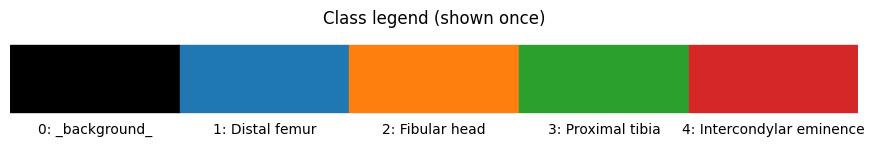

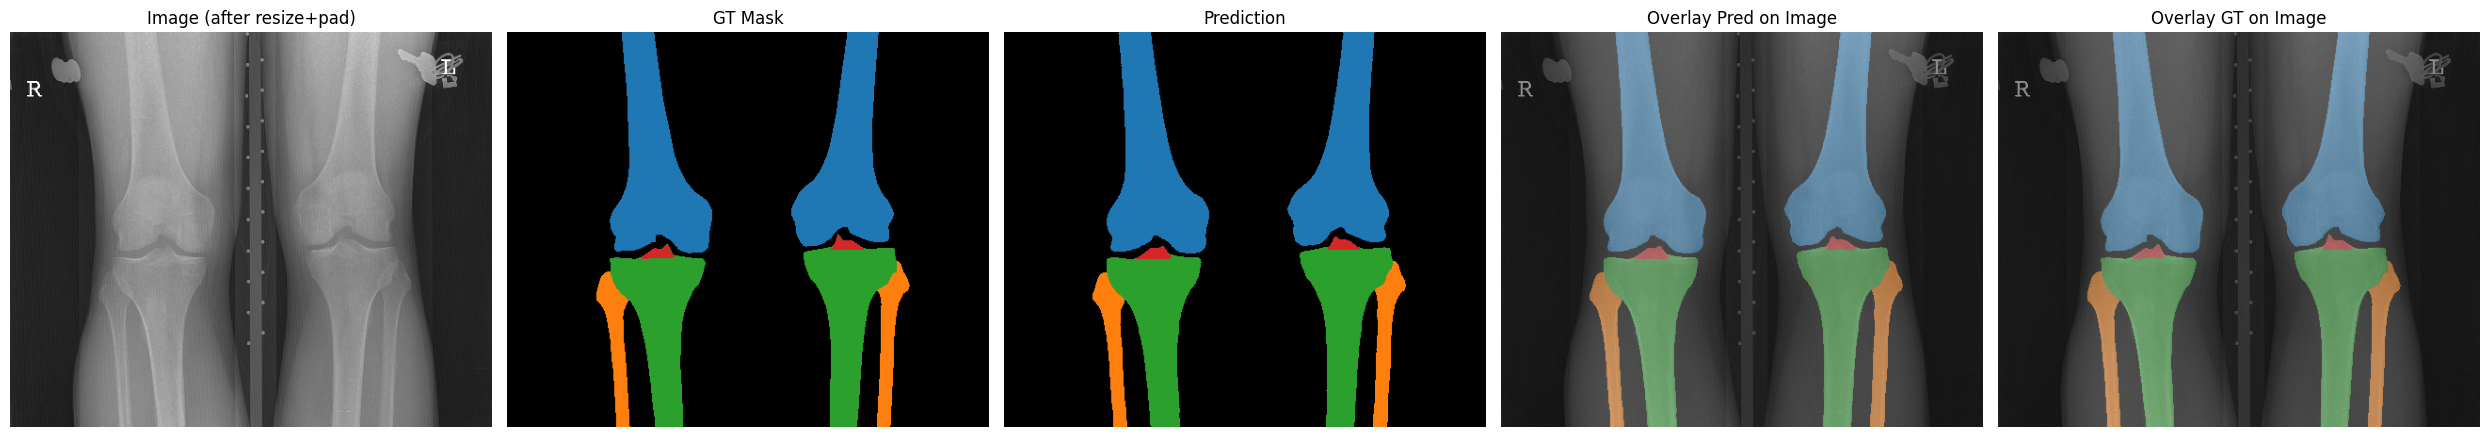

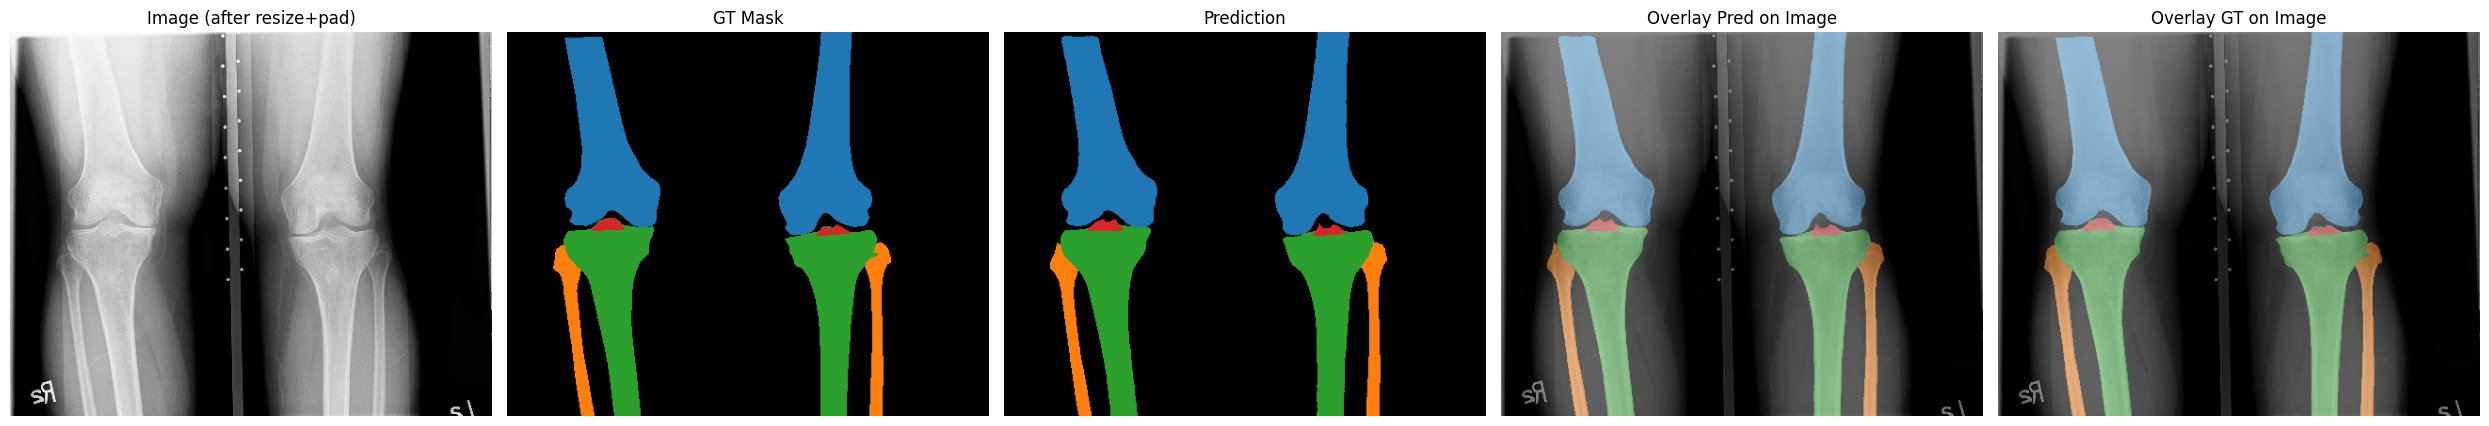

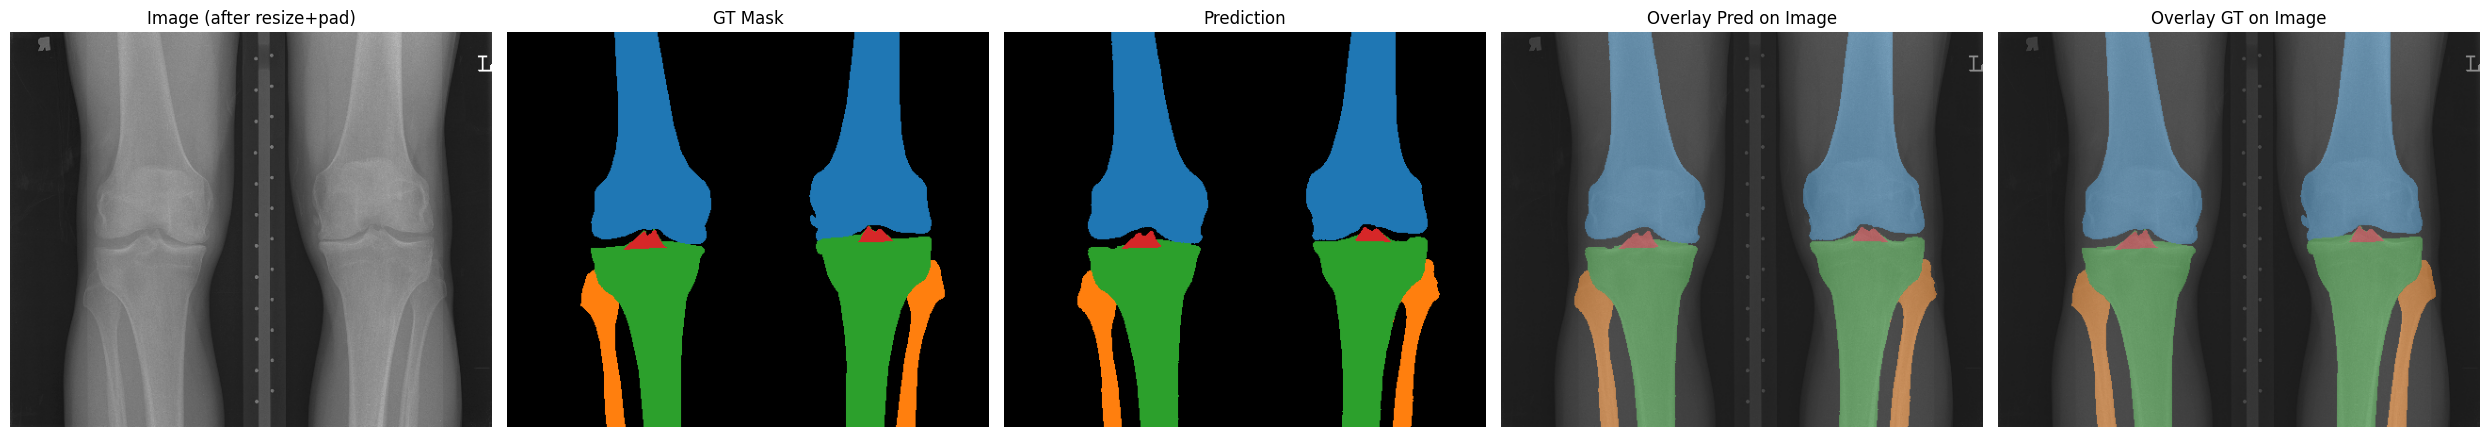

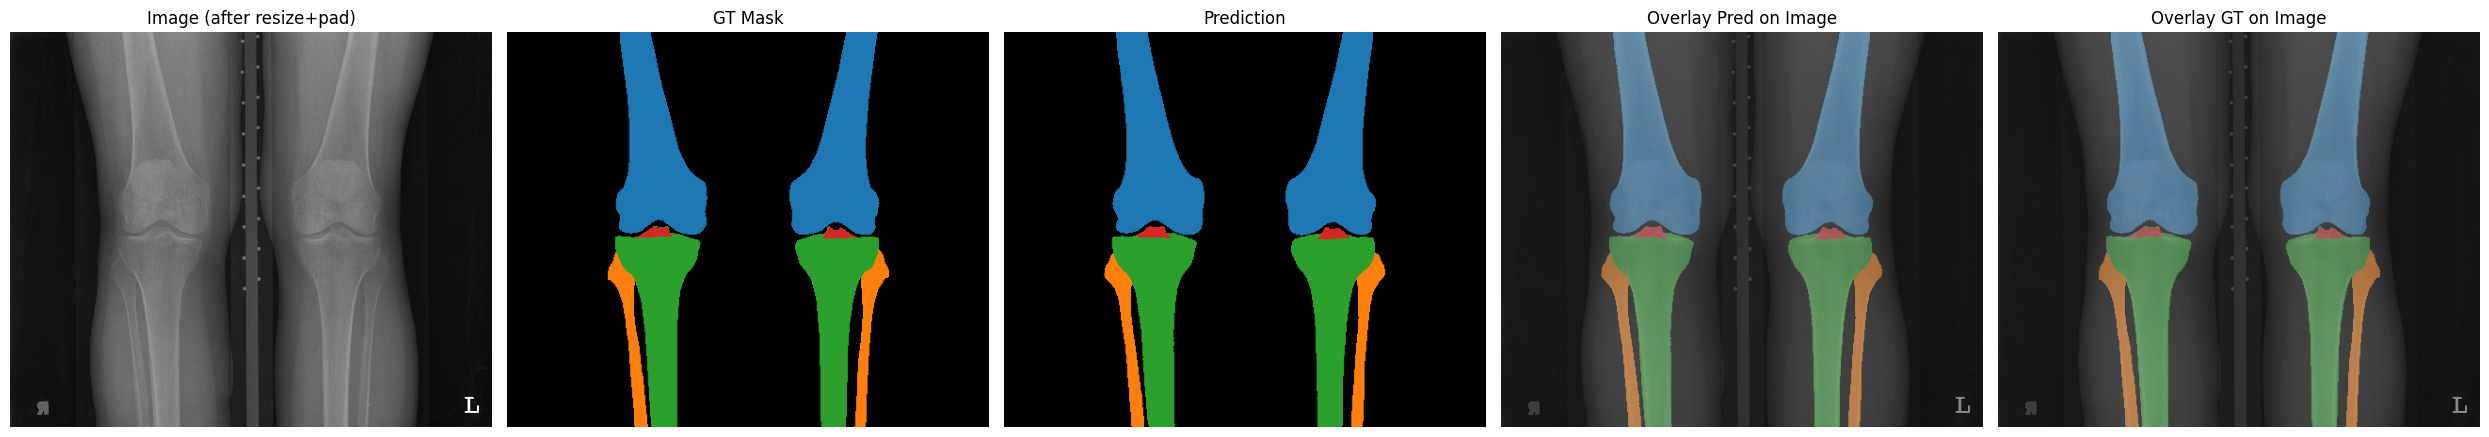

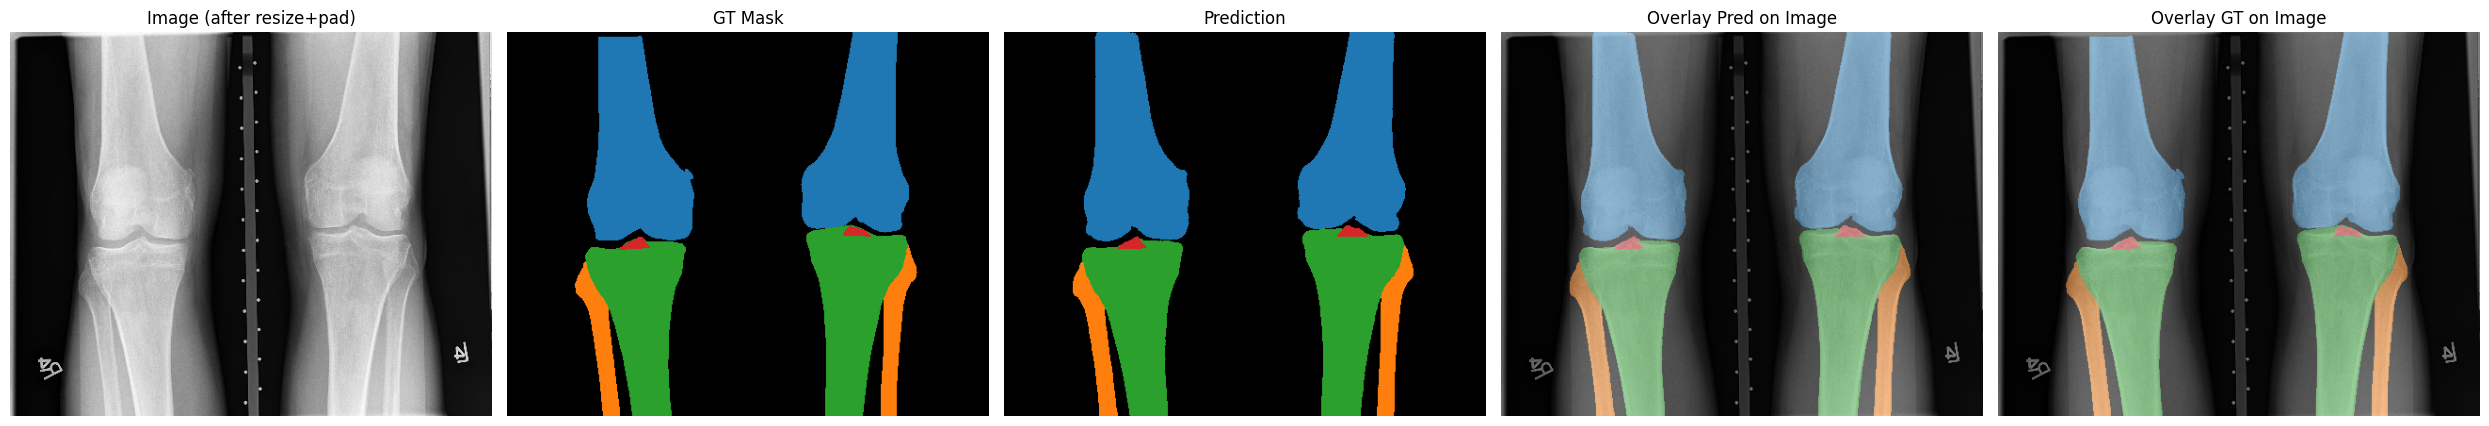

In [23]:
CLASS_BGR = [
    (0,0,0),
    (180,119,31),
    (14,127,255),
    (44,160,44),
    (40,39,214),
    # (189,103,148),
]
visualize_segmentation_oai_style(
    model=model,
    loader=test_loader,
    device=device,
    CLASS_BGR=CLASS_BGR,
    class_names=class_names,
    max_samples=5,
    alpha=0.45,
    crop_unpad=True,
    show_gt_overlay=True,
    show_legend_once=True,   # ✅ in 1 lần
)
